In [1]:

#!pip install nidaqmx
#!pip install matplotlib
#!pip install scipy
!set BLINKA_FT232H=1
import time
import re
import board
import busio
import digitalio
from adafruit_mcp230xx.mcp23017 import MCP23017
from datetime import datetime
import os
import scipy
from scipy.signal import savgol_filter

import numpy as np
import matplotlib.pyplot as plt
import nidaqmx
from nidaqmx.constants import LineGrouping
from nidaqmx.constants import AcquisitionType 
from nidaqmx.stream_readers import AnalogMultiChannelReader,AnalogSingleChannelReader
from nidaqmx.constants import WAIT_INFINITELY

In [2]:
class MUXBoard:
    def __init__(self):
        self.i2c = busio.I2C(board.SCL, board.SDA)
        self.mcp = MCP23017(self.i2c ,address=0x20)  # MCP23017 w/ A0 set
        self.mcp2= MCP23017(self.i2c,address=0x21 )  # MCP23017 w/ A0 set
        self.value=False
        cc=0
        value=False
        self.pins ={}
            
        chips = ['IC17','IC18']
        sides =['GPA','GPB']
        self.realPins ={}
        cc=0
        for chip in chips:
            cChip=0
            for side in sides:
                for i in range(0,8):
                    if cc<16:
                        m_mcp=self.mcp
                    else:
                        m_mcp=self.mcp2
                    pin0 =m_mcp .get_pin(cChip)
                    pin0.switch_to_output(value=True)
                    pin0.value = value
                    self.realPins[f"{chip}_{side}{i}"]={'index':cc,'value':value,'pin':pin0,'number':cChip,'board':m_mcp}
                    cc+=1
                    cChip+=1
                
        for k, v in self.realPins.items():
            setattr(self, f'_{k}', v)
            prop = property(lambda self, k=k: MUXBoard._getter(self, k))
            prop = prop.setter(lambda self, v, k=k: MUXBoard._setter(self, k, v))
            setattr(MUXBoard, k, prop)            

    def AllFalse(self):
        for k, field in self.realPins.items():
            field['value']=False
            field['pin'].value=False

    def AllTrue(self):
        for k, field in self.realPins.items():
            field['value']=True
            field['pin'].value=True
            
    def Set_RE(self,search,value,erbose=False):
        for k, field in self.realPins.items():
            m=re.search( search,k)        
            if m:
                v=field['value']
                field['value']=value
                field['pin'].value=value          
                if verbose:
                    print(f'{k}:{v}->{field["value"]}')            
            
    def _getter(self, k):
        print(f'g{k}')
        return getattr(self, f'_{k}')['value']
    
    def _setter(self, k, v):
        field =    getattr(self, f'_{k}')#    setattr(self, f'_{k}', v)     
        field['value']=v
        field['pin'].value=v
   
  

class Selector:
    def __init__(self, muxBoard):
        self.muxBoard = muxBoard
        assignments = {'E':['IC17','GPB'],'S':['IC17','GPA'],'W':['IC18','GPB'],'N':['IC18','GPA']}
        self.shorted =[]
        self.junctions ={}
        for assignment in assignments:
            side = assignments[assignment]
            for pin in  muxBoard.realPins:
                if (side[0] in pin) and (side[1] in pin):
                    i = int( pin.replace(f'{side[0]}_{side[1]}',''))
                    self.junctions[assignment + str(i)]=muxBoard.realPins[pin]
                
        for k, v in self.junctions.items():
            setattr(self, f'_{k}', v)
            prop = property(lambda self, k=k: Selector._getter(self, k))
            prop = prop.setter(lambda self, v, k=k: Selector._setter(self, k, v))
            setattr(Selector, k, prop)
            
    def setBlock(self,block,value):
        for k, field in self.junctions.items():
            if k.startswith(block):
                field['value']=value
                field['pin'].value=value        
                
    def getBlock(self,block):
        values =''
        for k, field in self.junctions.items():
            if k.startswith(block):
                values += k + ':' + str(field['value']) + ' '
        return values
                
    @property
    def N(self):
        return self.getBlock('N')

    @N.setter
    def N(self,value):
        self.setBlock('N',value)

    @property
    def S(self):
        return self.getBlock('S')

    @S.setter
    def S(self,value):
        self.setBlock('S',value)

    @property
    def W(self):
        return self.getBlock('W')

    @W.setter
    def W(self,value):
        self.setBlock('W',value)

    @property
    def E(self):
        return self.getBlock('E')

    @E.setter
    def E(self,value):
        self.setBlock('E',value)
                
    def Activate(self, junctions,verbose=False):
        junctions = junctions.upper()
        for k, field in self.junctions.items():
            if (k in junctions ) or junctions=='ALL':
                field['value']=True
                field['pin'].value=True  
                if verbose:
                    print(f'{k}:{field["value"]}')
                
    def DeActivate(self, junctions,verbose=False):
        junctions = junctions.upper()
        for k, field in self.junctions.items():
            if (k in junctions )  or junctions=='ALL':
                field['value']=False
                field['pin'].value=False
                if verbose:
                    print(f'{k}:{field["value"]}')

    def GroundAll(self):
        for k, field in self.junctions.items():
            field['value']=False
            field['pin'].value=False

    def GroundNone(self):
        for k, field in self.junctions.items():
            field['value']=True
            field['pin'].value=True
            
    def ActivateAll(self):
        self.GroundNone()
            
    def ActivateRE(self,search,verbose=False):
        for k, field in self.junctions.items():
            m=re.search( search,k)        
            if m:
                v=field['value']
                field['value']=True
                field['pin'].value=True          
                if verbose:
                    print(f'{k}:{v}->{field["value"]}')
                
    def DeactivateRE(self,search,verbose=False):
        for k, field in self.junctions.items():
            m=re.search( search,k)           
            if m:
                v=field['value']
                field['value']=True
                field['pin'].value=True       
                if verbose:
                    print(f'{k}:{v}->{field["value"]}')

    def _getter(self, k):
        return getattr(self, f'_{k}')['value']
    
    def _setter(self, k, v):
        field =    getattr(self, f'_{k}')#    setattr(self, f'_{k}', v)     
        field['value']=v
        field['pin'].value=v    

    def ChangeJunction(self, junctionName, value):
        self.junctions[junctionName]['value']=value
        self.junctions[junctionName]['pin'].value=value

    def NumberActive(self):
        active=len([ x for x in self.junctions if (True==self.junctions[x]['value'])])
        return active

    def Active(self):
        active=([ x for x in self.junctions if (True==self.junctions[x]['value'])])
        return active
    
    def RemoveShorted(self):
        for shorted in self.shorted:
            self.ChangeJunction(shorted,False)
            


class PotentioStat:
    def __init__(self, selector):
        self.selector = selector
        self.WE1_i  = "Dev1/ai0"
        self.WE2_i  = "Dev1/ai1"
        self.WE1_vm = "Dev1/_ao1_vs_aognd"
        self.WE2_vm = "Dev1/_ao0_vs_aognd"
        self.WE1_v  = "Dev1/ao1"
        self.WE2_v  = "Dev1/ao0"
        self.useCEProtection=True

    def UseCEProtection(self, value):
        self.useCEProtection=value

    def IVSweep(self, maxVoltage, slew_mV_s, samplesPerSec=10000, cut=500, filter=True,svPoints= 451,svOrder= 3, plot=False ):
        self._TurnOFF_CE()
        sweep,We1,We2= self._CVSweep(0,maxVoltage,-1*maxVoltage, 0, slew_mV_s=slew_mV_s, samplesPerSec=samplesPerSec, cut=cut, filter=filter,svPoints= svPoints,svOrder= svOrder)
        if plot:
            plt.plot(sweep*1000,We1,label='BE')
            plt.plot(sweep*1000,We2,label='TE')
            plt.xlabel('BE Potential (mV vs GND/TE)')
            plt.ylabel('Current (nA)')
            plt.legend()
            plt.show()
        return sweep,We1,We2
        
        
    def _CVSweep(self,startVoltage, secondVoltage, thirdVoltage, endVoltage,slew_mV_s,bias2=0, flipChannels=True, bothChannels=False, samplesPerSec=10000, cut=500, filter=True,svPoints= 451,svOrder= 3 ):
        samplesPerPoint=1
            
        slew_V_s=slew_mV_s/1000
        secPerSample=1.0/samplesPerSec*samplesPerPoint
        s1 =np.linspace(startVoltage,secondVoltage,int( np.abs(secondVoltage-startVoltage)/slew_V_s/secPerSample))
        s2 = np.linspace(secondVoltage,thirdVoltage,int( np.abs(secondVoltage-thirdVoltage)/slew_V_s/secPerSample))
        s3 = np.linspace(thirdVoltage,endVoltage,int( np.abs(thirdVoltage-endVoltage)/slew_V_s/secPerSample))
        biasi = np.concatenate( [s1,s2,s3])
        totalPoints=len(biasi)
        if bothChannels:
            biasi = np.stack([biasi,biasi])
        else:
            bias2 = np.zeros_like(biasi)+bias2
            if flipChannels:
                biasi = np.stack([biasi,bias2])
            else:
                biasi = np.stack([bias2,biasi])
        
        
        with nidaqmx.Task(new_task_name ='Current_MonTask') as Current_MonTask, nidaqmx.Task(new_task_name ='biasTask') as biasTask:
        
            Current_MonTask.ai_channels.add_ai_voltage_chan(self.WE1_i)
            Current_MonTask.ai_channels.add_ai_voltage_chan(self.WE2_i)
            Current_MonTask.ai_channels.add_ai_voltage_chan(self.WE1_vm)
            Current_MonTask.ai_channels.add_ai_voltage_chan(self.WE2_vm)
            
            
            Current_MonTask.timing.cfg_samp_clk_timing(samplesPerSec, source="", sample_mode=AcquisitionType.CONTINUOUS, samps_per_chan=samplesPerSec)
            #Current_Reader = AnalogMultiChannelReader(Current_MonTask.in_stream )

            
            biasTask.ao_channels.add_ao_voltage_chan(self.WE1_v)
            biasTask.ao_channels.add_ao_voltage_chan(self.WE2_v)
        
            for task in (Current_MonTask, biasTask):
                    task.timing.cfg_samp_clk_timing( rate=samplesPerSec, source="OnboardClock", samps_per_chan=totalPoints     )
        
            biasTask.triggers.start_trigger.cfg_dig_edge_start_trig(
               Current_MonTask.triggers.start_trigger.term
            )
                    
            biasTask.write(biasi , auto_start=False)
            biasTask.start()
            currents = Current_MonTask.read(totalPoints, timeout=WAIT_INFINITELY)
        currents=np.asarray(currents)

       
        if bothChannels:
            sweep = currents[2,cut:]  
            We1 = (currents[0,cut:]-sweep)*100
            We2 = (currents[1,cut:]-sweep)*100
        elif  flipChannels :
            sweep = currents[2,cut:]
            We1 = (currents[0,cut:])*100
            We2 = (currents[1,cut:]-sweep)*100
        else:
            sweep = currents[3,cut:]
            We1 = (currents[0,cut:]-sweep)*100
            We2 = (currents[1,cut:])*100
    
        if filter:
            We1=savgol_filter(We1, svPoints ,svOrder)
            We2=savgol_filter(We2, svPoints ,svOrder)
        
        return sweep,We1,We2
    
    def _TurnOFF_CE(self):
        with nidaqmx.Task(new_task_name ='CEControlTask') as CETask:
            CETask.do_channels.add_do_chan("Dev1/port0/line6:7", line_grouping=LineGrouping.CHAN_PER_LINE)
            CETask.write([False,False], auto_start=True)
            time.sleep(.25)
            
    def _TurnON_CE(self, waitTime=1):
        with nidaqmx.Task(new_task_name ='CEControlTask') as CETask:
            CETask.do_channels.add_do_chan("Dev1/port0/line6:7", line_grouping=LineGrouping.CHAN_PER_LINE)
            CETask.write([True,self.useCEProtection], auto_start=True)
            time.sleep(1)
    
    def TE_CV(self,startV, maxV, minV, endV, slew_mV_s, plot=False, waitTime=1):
        self._TurnON_CE(waitTime)
        sweep,We1,We2=  self._CVSweep(startV, maxV, minV, endV,bias2=0,flipChannels=True,slew_mV_s=slew_mV_s)
        if plot:
            plt.plot(sweep*1000,We1,label='BE')
            plt.plot(sweep*1000,We2,label='TE')
            plt.xlabel('TE Potential (mV vs Ag/AgCl)')
            plt.ylabel('Current (nA)')
            plt.legend()
            plt.show()
        return sweep,We1,We2
    
    def BE_CV(self,startV, maxV, minV, endV, slew_mV_s, plot=False, waitTime=1):
        self._TurnON_CE(waitTime)   
        sweep,We1,We2=  self._CVSweep(startV, maxV, minV, endV,bias2=0,flipChannels=False,slew_mV_s=slew_mV_s)
        if plot:
            plt.plot(sweep*1000,We1,label='BE')
            plt.plot(sweep*1000,We2,label='TE')
            plt.xlabel('BE Potential (mV vs Ag/AgCl)')
            plt.ylabel('Current (nA)')
            plt.legend()
            plt.show()
        return sweep,We1,We2

    def BETE_CV(self,startV, maxV, minV, endV, slew_mV_s, plot=False, waitTime=1):
        self._TurnON_CE(waitTime)      
        sweep,We1,We2=  self._CVSweep(startV, maxV, minV, endV, slew_mV_s=slew_mV_s,bothChannels=True)
        if plot:
            plt.plot(sweep*1000,We1,label='BE')
            plt.plot(sweep*1000,We2,label='TE')
            plt.xlabel('BETE  Potential (mV vs Ag/AgCl)')
            plt.ylabel('Current (nA)')
            plt.legend()
            plt.show()
        return sweep,We1,We2

    def Save(self,sweep,We1,We2,wafer,chip,zone,stage):
        if os.path.exists(f'C:/Data/MUX/{wafer}')==False:
            os.mkdir(f'C:/Data/MUX/{wafer}')
        if os.path.exists(f'C:/Data/MUX/{wafer}/{chip}')==False:    
            os.mkdir(f'C:/Data/MUX/{wafer}/{chip}')
        
        

        now = datetime.now()
        date_time = now.strftime("%Y-%m-%d_%H-%M-%S")
        filename=f'C:/Data/MUX/{wafer.upper()}/{chip.upper()}/{date_time}_{zone.upper()}_{stage}.npy'
        with open(filename, 'wb') as f:
            np.save(f, np.array(self.selector.Active()))
            np.save(f, np.array(sweep))
            np.save(f, np.array(We1))
            np.save(f, np.array(We2))
            

    def FindShorts(self,slew_mV_s=500,threshold_nA=450, verbose=False, plots=False):
        self.selector.GroundAll()
        shorted=[]
        if plots:
            fig,ax=plt.subplots(2, 2, figsize=(15,15))

            ax=np.ravel(ax)
            fig.suptitle(f'Electrode Sweeps')
            ax[0].set_xlabel('Top Electrode (V) ')
            ax[0].set_title('Unshorted - TE')
            ax[0].set_ylabel('Current (nA)')

            ax[1].set_title('Normalized - TE')
            ax[1].set_xlabel('Top Electrode (V) ')
            ax[1].set_ylabel('Normalized Current')

            ax[2].set_title('Unshorted - BE')
            ax[2].set_xlabel('Top Electrode (V) ')

            ax[3].set_title('Shorted - BE')
            ax[3].set_xlabel('Top Electrode (V) ')
        
        for junction in s.junctions:
            if verbose:
                print(junction,end=',')
            self.selector.ChangeJunction(junction,True)
            sweepV,We1,We2=self.IVSweep(.2, slew_mV_s=slew_mV_s)
        
            M=np.max(We1)
            m=np.min(We1)
            
            if np.max( [ M, np.max(We2), -1*m, -1*np.min(We1) ])>threshold_nA:
                shorted.append(junction)
                ax[3].plot(sweepV,We1,label='TE')
                ax[3].plot(sweepV,We2,label='BE')
            elif plots:
                ax[0].plot(sweepV,We1,label='TE')
                ax[1].plot(sweepV,(We1-m)/(M-m),label='TE')
                ax[2].plot(sweepV,We2,label='BE')
                
            self.selector.ChangeJunction(junction,False)
            
        if plots:
            plt.show()            
        self.selector.shorted=shorted
        if verbose:
            print("Shorted junctions:")
            print(shorted)
            

In [3]:
mux=MUXBoard()   #set up communication with board
s=Selector(mux)  #map out the channels
potentioStat =PotentioStat(s) #


In [4]:
s.GroundAll()

E0,

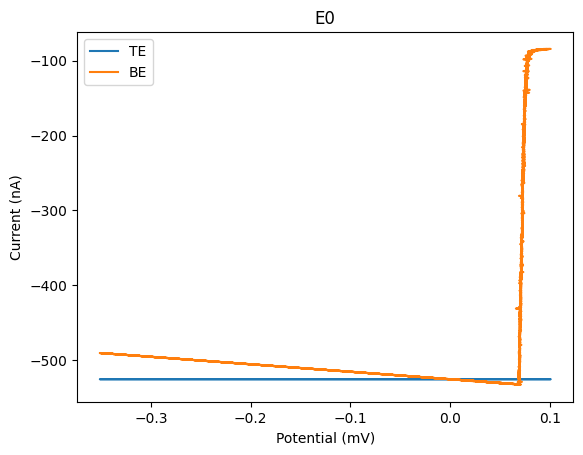

E1,

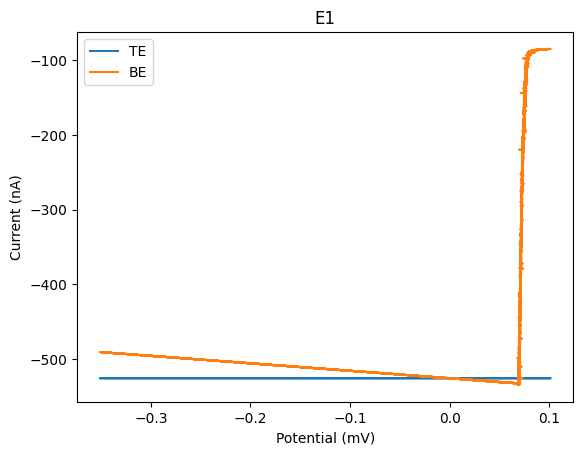

E2,

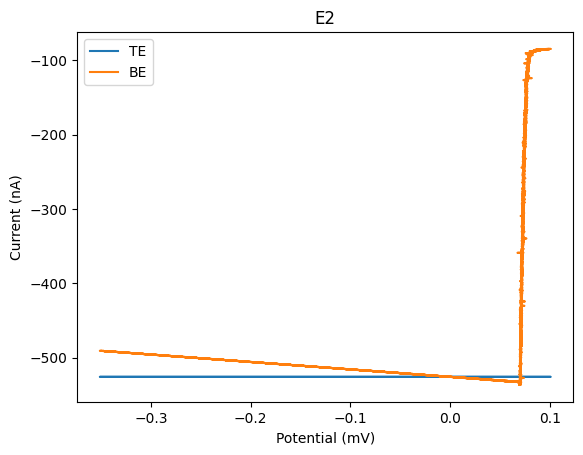

E3,

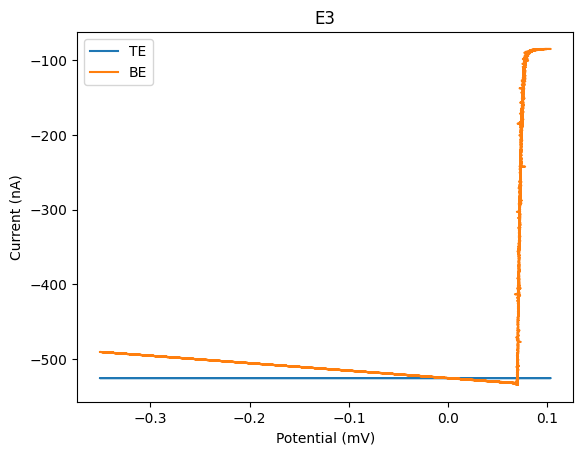

E4,

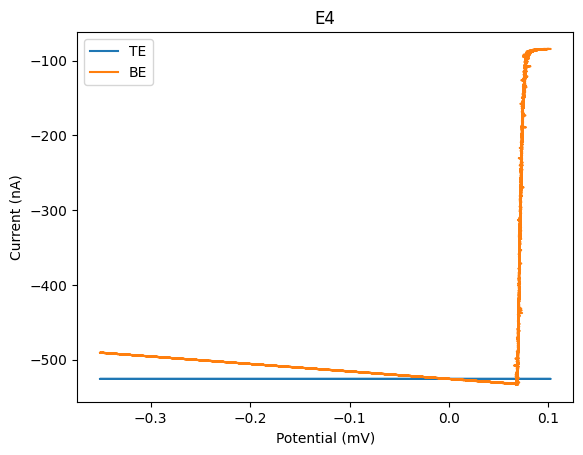

E5,

KeyboardInterrupt: 

In [6]:
s.GroundAll()
traces ={}
for junction in s.junctions:
    print(junction,end=',')
    potentioStat.selector.ChangeJunction(junction,True)
    
    #plt.plot(traces[junction][0],traces[junction][1],'k',alpha=.3,label='TE_IV')
    #plt.plot(traces[junction][0],traces[junction][2],'k',alpha=.3,label='BE_IV')
    
    #sweepV,We1,We2=potentioStat.IVSweep(.1, slew_mV_s=20)
    sweepV,We1,We2=potentioStat.TE_CV(startV=0, maxV=.1, minV=-.35, endV=0, slew_mV_s=20)

    M=np.max(We1)
    m=np.min(We1)
    
   
    plt.plot(sweepV,We1,label='TE')
    plt.plot(sweepV,We2,label='BE')

    
    
    plt.ylabel('Current (nA)') 
    plt.xlabel('Potential (mV)')
    plt.title(junction)
    plt.legend()
    plt.show()
    traces[junction+"TE_CV"]=[sweepV,We1,We2]
    potentioStat.selector.ChangeJunction(junction,False)

In [53]:
for t in traces:
    with open(f'C:/MUXpy/W049/C11Chip/ivTraces_{t}.npy','wb') as fp:
        np.save(fp,np.array(traces[t][0]))
        np.save(fp,traces[t][1])
        np.save(fp,traces[t][2])

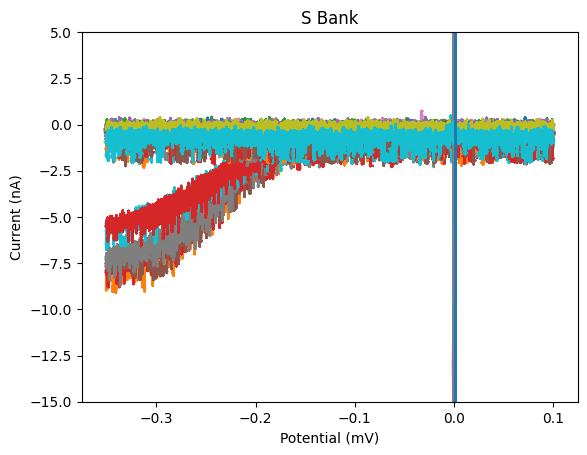

In [59]:
tracenames=[t for t in traces if 'S' in t]
for t in tracenames:
    sweepV,We1,We2=traces[t]
    plt.plot(sweepV,We1,label='TE')
    plt.plot(sweepV,We2,label='BE')
    
plt.ylabel('Current (nA)') 
plt.ylim([-15, 5])
plt.xlabel('Potential (mV)')
plt.title('S Bank')
plt.show()
    

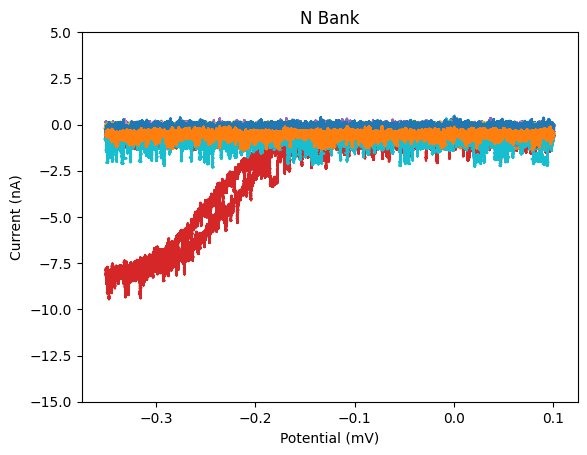

In [60]:
tracenames=[t for t in traces if 'N' in t]
for t in tracenames:
    sweepV,We1,We2=traces[t]
    plt.plot(sweepV,We1,label='TE')
    plt.plot(sweepV,We2,label='BE')
    
plt.ylabel('Current (nA)') 
plt.ylim([-15, 5])
plt.xlabel('Potential (mV)')
plt.title('N Bank')
plt.show()

E0,E1,E2,E3,E4,E5,E6,E7,S0,S1,S2,S3,S4,S5,S6,S7,W0,W1,W2,W3,W4,W5,W6,W7,N0,N1,N2,N3,N4,N5,N6,N7,

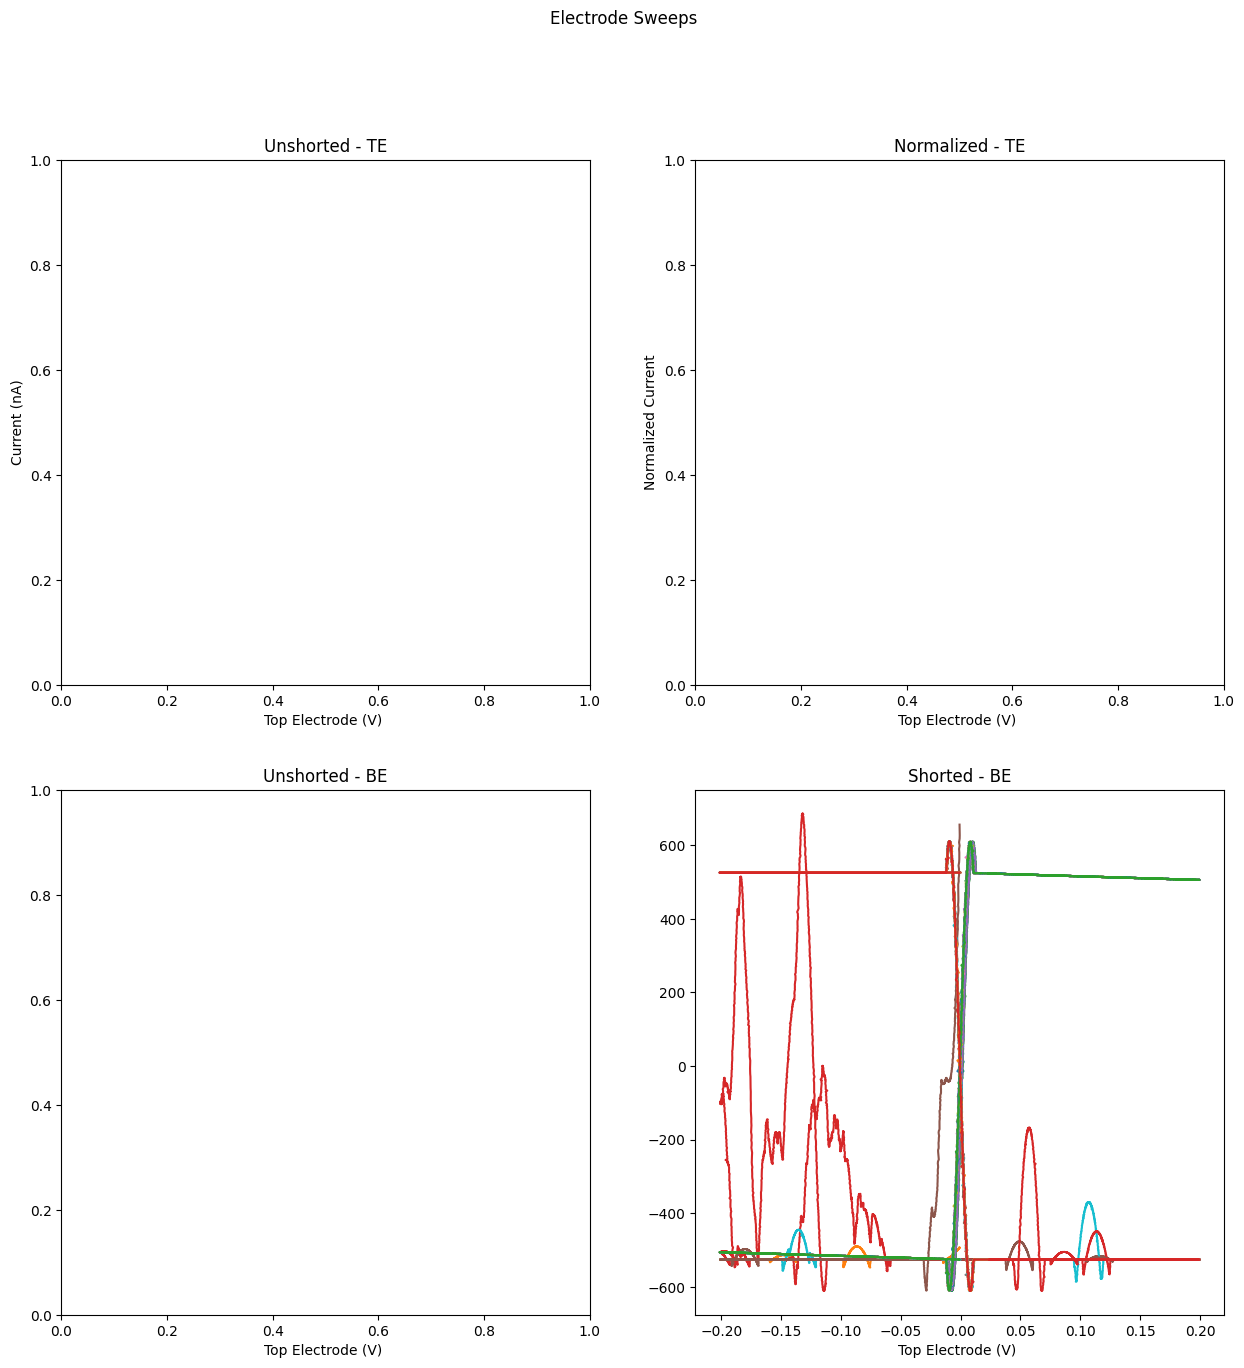

Shorted junctions:
['E0', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'W0', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6', 'W7', 'N0', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7']


In [25]:

potentioStat.FindShorts(verbose=True,plots=True)

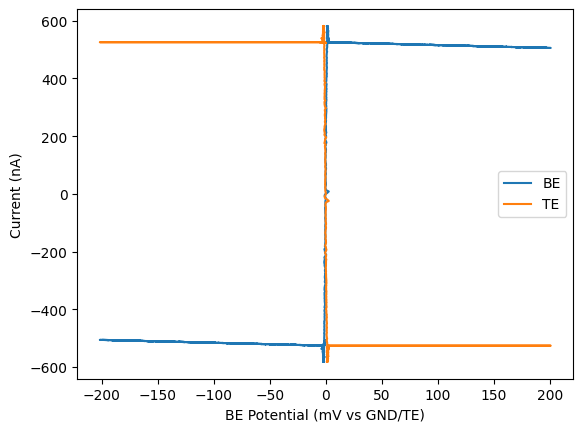

In [28]:
wafer='W048'
chip ='T3'

s.GroundAll()
s.W=True
s.E=True
s.S=True
s.N=True
s.RemoveShorted()
sweep,TE,BE=potentioStat.IVSweep(.2, 100,plot=True)
potentioStat.Save(sweep,TE,BE,wafer,chip,'W','Initial_IV')

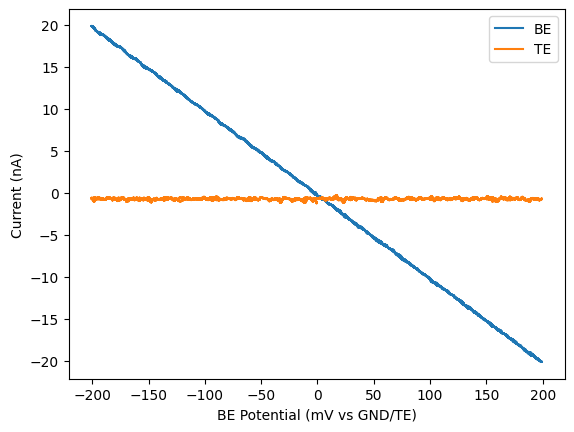

In [6]:
sweep,TE,BE=potentioStat.IVSweep(.2, 100,plot=True)

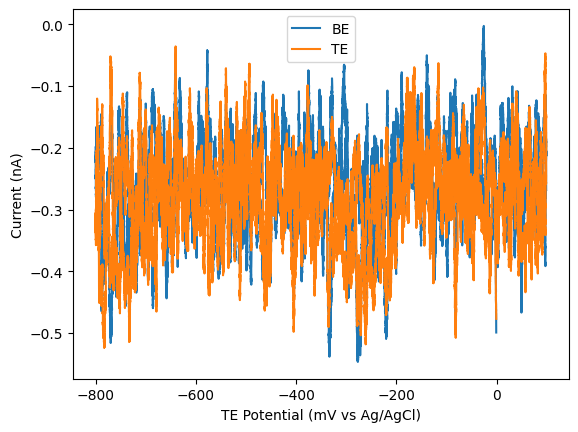

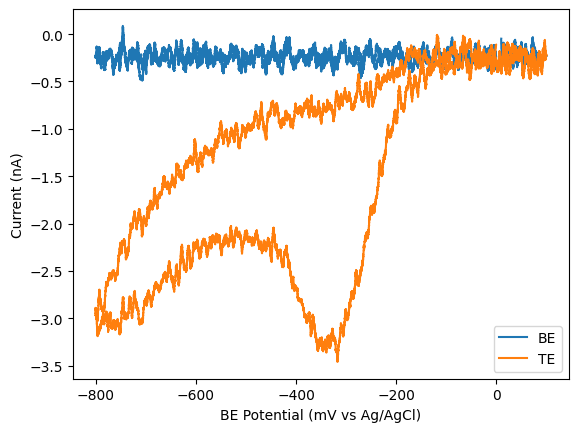

In [5]:
#s.GroundAll()
#s.W=True

wafer='w'
chip='t'
sweep,TE,BE=potentioStat.TE_CV(0, .1, -.8, 0, slew_mV_s=200,plot=True)
#potentioStat.Save(sweep,TE,BE,wafer,chip,'W','Initial_TE_CV')

sweep,TE,BE=potentioStat.BE_CV(0, .1, -.8, 0, slew_mV_s=200,plot=True)
#potentioStat.Save(sweep,TE,BE,wafer,chip,'W','Initial_BE_CV')

(2, 180000)


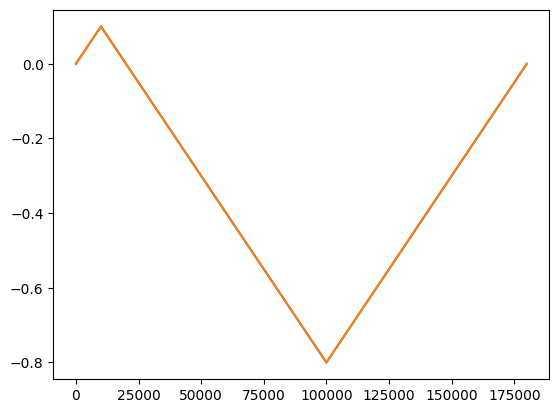

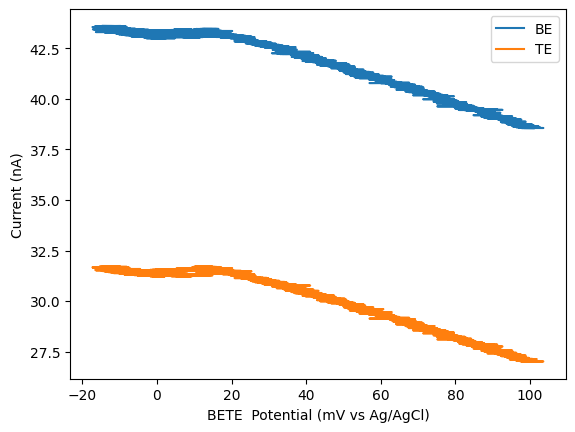

In [4]:
s.ActivateAll()
#s.W=True

sweep,TE,BE=potentioStat.BETE_CV(0, .1, -.8, 0, slew_mV_s=100,plot=True)
#potentioStat.Save(sweep,TE,BE,wafer,chip,'W','Initial_BETE_CV')

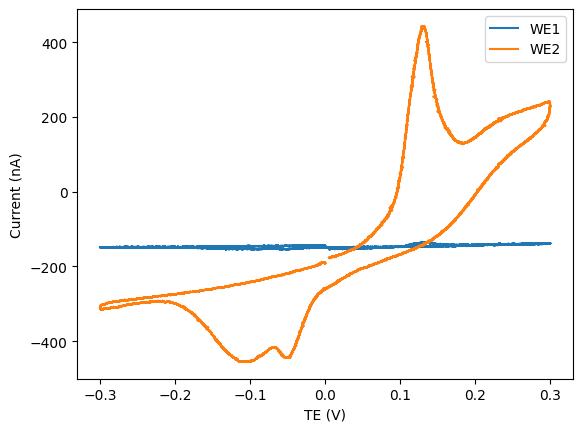

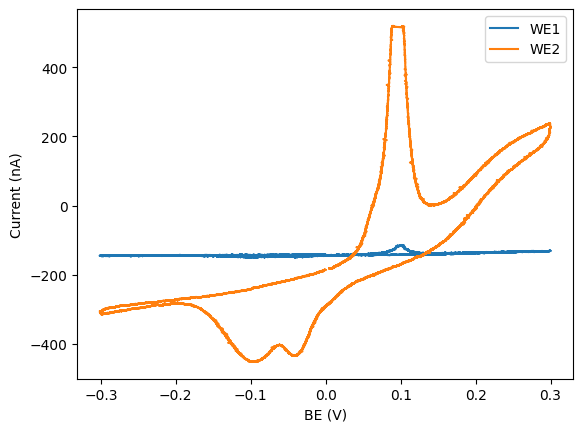

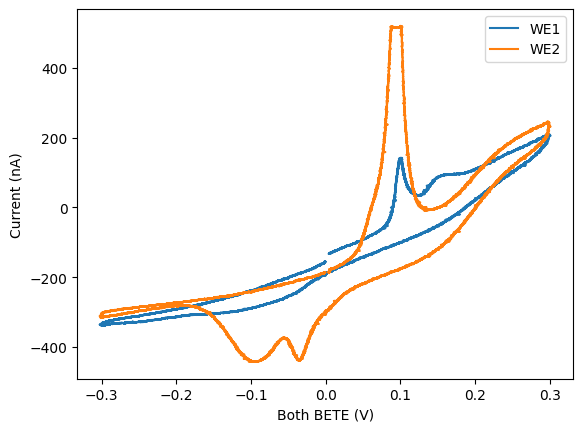

In [7]:
s.ActivateAll()
s.RemoveShorted()

sweep,TE,BE=potentioStat.TE_CV(0, .3, -.3, 0, slew_mV_s=100,plot=True)
potentioStat.Save(sweep,TE,BE,wafer,chip,'All','Initial_TE_CV')

sweep,TE,BE=potentioStat.BE_CV(0, .3, -.3, 0, slew_mV_s=100,plot=True)
potentioStat.Save(sweep,TE,BE,wafer,chip,'All','Initial_BE_CV')

sweep,TE,BE=potentioStat.BETE_CV(0, .3, -.3, 0, slew_mV_s=100,plot=True)
potentioStat.Save(sweep,TE,BE,wafer,chip,'All','Initial_BETE_CV')